In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper as nw
import nawrapper.maputils as maputils

import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

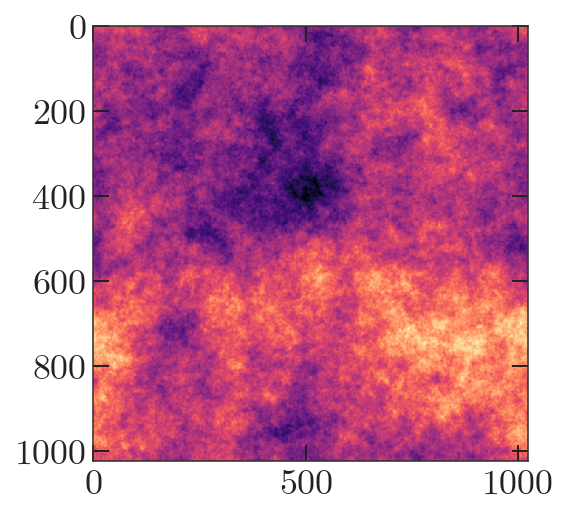

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

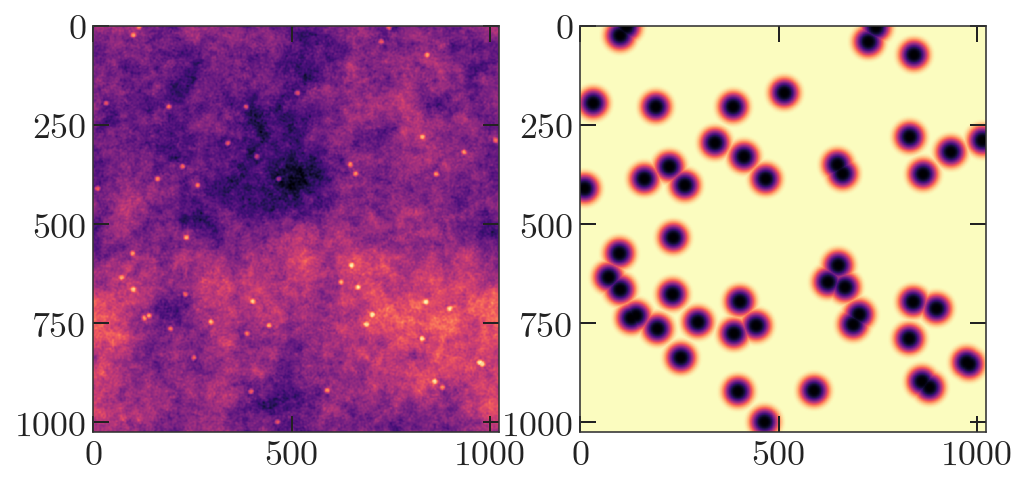

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-maputils.apod_C2(mask, 0.1)
imap += point_source_map
mask = maputils.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

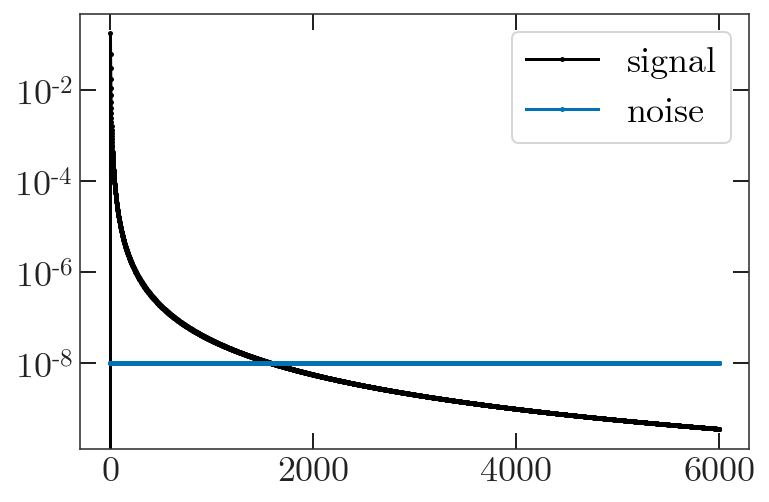

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="signal")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([ 1.29886352e-04, -6.46868206e-06,  6.45461736e-06,  1.85150239e-06,
        1.70787888e-06,  7.25557497e-07,  9.07051717e-07,  3.30820593e-07,
        4.27003583e-07,  2.05926826e-07,  1.84023971e-07,  1.33724427e-07,
        1.14449444e-07,  4.93589623e-08,  1.05791310e-07,  4.32592558e-08,
        5.55572699e-08,  3.38286818e-08,  4.21382110e-08,  2.26656719e-08,
        3.15680111e-08,  2.81335485e-08,  2.48322034e-08,  1.22778192e-08,
        2.31892607e-08,  1.43085782e-08,  1.36236751e-08,  1.57807431e-08,
        1.14742310e-08,  1.39259353e-08,  1.25751026e-08,  1.00931976e-08,
        7.86210337e-09,  8.72676714e-09,  8.33431950e-09,  8.95736307e-09,
        7.44595969e-09,  4.16191038e-09,  8.38301803e-09,  5.81586668e-09,
        6.82487379e-09,  3.92169813e-09,  4.32191300e-09,  4.10594029e-09,
        4.55989969e-09,  3.26755692e-09,  1.98386345e-09,  1.81440722e-09,
        1.58661852e-09,  1.29501180e-09,  7.39200505e-10,  6.92915879e-10,
        8.27642156

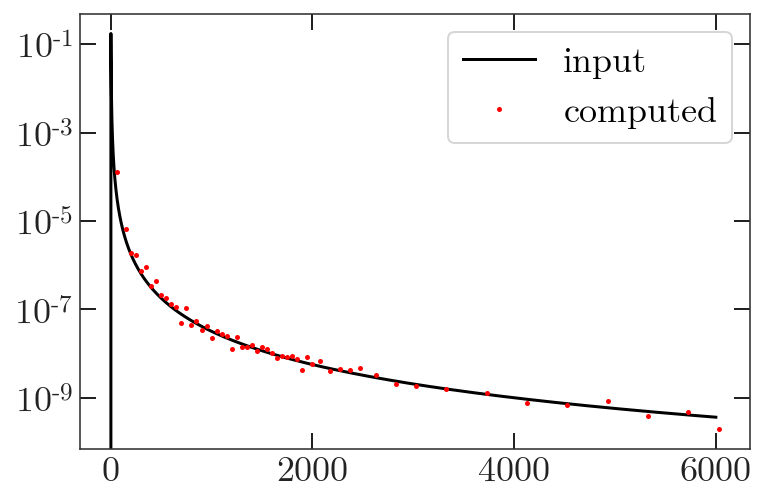

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')